### Piyavskii Search is an alternative to line search and will find the true min along the search plane

### 2-D Objective

In [1]:
using Plots, Zygote, LinearAlgebra

In [2]:
SawTooth(x1, x2, z1, z2, L) = (z1 - z2)/2L + (x1 + x2)/2.0, (z1 + z2)/2 + L*(x1 - x2)/2

function Piyavskii(f, a, b, L, ϵ, m)
    fa = f(a); fb = f(b)
    x, y = SawTooth(a, b, fa, fb, L)

    x_list = [a, x, b]
    y_list = [fa, y, fb]
    X = [a, b]
    Y = [fa, fb]
    α_list = Float64[]
    β_list = Float64[]
    minpos = 0

    for i = 1:m
        minpos = argmin(y_list)
        y_list[minpos] = f(x_list[minpos])

        for j = 1:2
            pos1 = minpos - j%2
            pos2 = minpos + (j+1)%2
            x, y = SawTooth(x_list[pos1], x_list[pos2], y_list[pos1], y_list[pos2], L)
            append!(x_list, x); append!(y_list, y);
            append!(X, x)
            append!(Y, f(x))
        end

        p = sortperm(x_list); permute!(x_list, p); permute!(y_list, p)

        α = minimum(y_list)
        β, minpos = findmin(Y)
        append!(α_list, α); append!(β_list, β)


        if abs(β - α) <= ϵ        
            break
        end
    end

    x = X[minpos]
    y = Y[minpos]

    return x, y, x_list, y_list, α_list, β_list
end

Piyavskii (generic function with 1 method)

In [3]:
x1 = [-1.9, (rand() - 0.5)*4]
x2 = [1.9, (rand() - 0.5)*4]

f(x,y) = x*sin(10*y) + y*cos(10*x) + 0.5*x^2 + 0.5*y^2
f(x) = f(x...)

f (generic function with 2 methods)

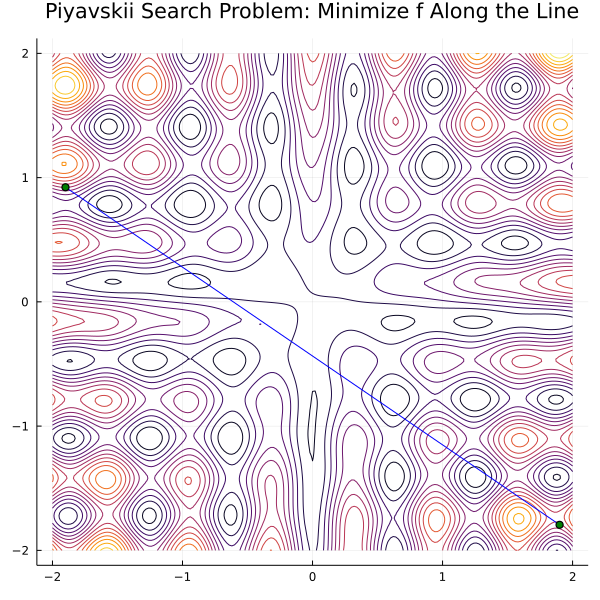

In [4]:
aa = -2:.02:2
bb = -2:.02:2

contour(aa, bb, f, fill=false, colorbar = false, dpi = 100, title = "Piyavskii Search Problem: Minimize f Along the Line")
plot!(size=(600,600), legend=:none)

plot!([x1[1], x2[1]], [x1[2], x2[2]], color=:blue, label = false)
scatter!([x1[1]], [x1[2]], color=:green, label = "x1")
scatter!([x2[1]], [x2[2]], color=:green, label = "x2")

In [5]:
ell(t) = x1 + t*(x2 - x1)
phi(t) = f(ell(t))

phi (generic function with 1 method)

In [6]:
projectedMin = Piyavskii(phi, 0.0, 1.0, 12.0, 1e-5, 5000);

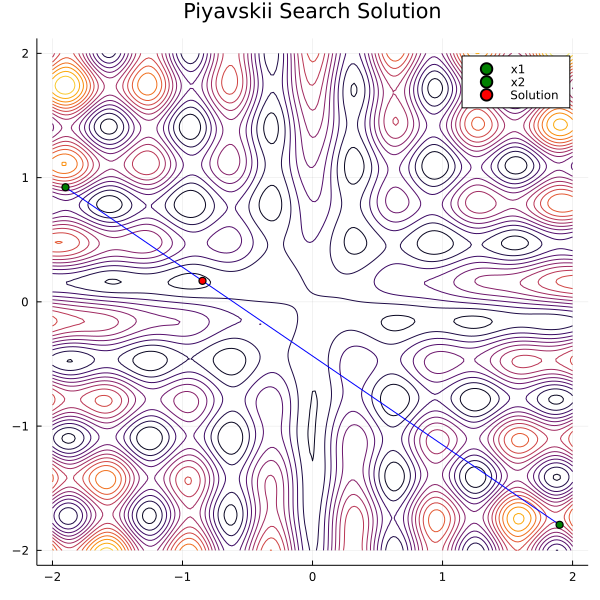

In [7]:
aa = -2:.02:2
bb = -2:.02:2

contour(aa, bb, f, fill=false, colorbar = false, dpi = 100, title = "Piyavskii Search Solution")
plot!(size=(600,600))

plot!([x1[1], x2[1]], [x1[2], x2[2]], color=:blue, label = false)
scatter!([x1[1]], [x1[2]], color=:green, label = "x1")
scatter!([x2[1]], [x2[2]], color=:green, label = "x2")
ℓ = ell(projectedMin[1])
scatter!([ℓ[1]], [ℓ[2]], color=:red, label = "Solution")

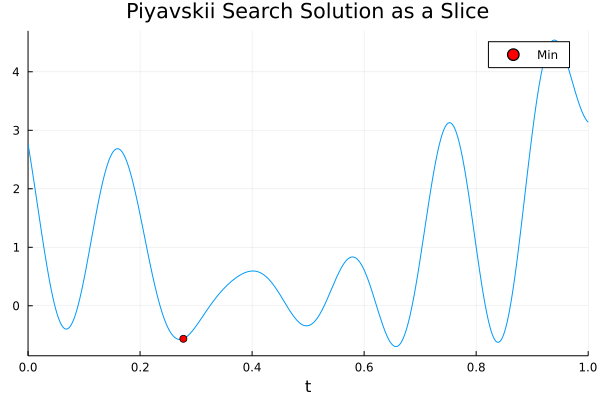

In [8]:
plot(phi, xrange = (0, 1), title = "Piyavskii Search Solution as a Slice", label = false, xlabel = "t")
scatter!([projectedMin[1]], [phi(projectedMin[1])], color=:red, label = "Min")

### N-D Objective

In [9]:
n = 50

x1 = (rand(n) .- 0.5)*10
x2 = (rand(n) .- 0.5)*10
x1[1] = -5
x2[1] = 5

f(x) = sum(sin(x[i])*sin(i*x[i]^2/pi)^5 for i in 1:n) #Michalewicz Function

f (generic function with 2 methods)

In [10]:
ell(t) = x1 + t*(x2 - x1)
phi(t) = f(ell(t))

phi (generic function with 1 method)

In [11]:
L = -Inf
for i in 1:1000
    fp = phi'((rand()-0.5)*10)
    if(fp > L)
        L = fp
    end
end
L *= 1.3

projectedMin = Piyavskii(phi, 0.0, 1.0, L, 1e-5, 5000);

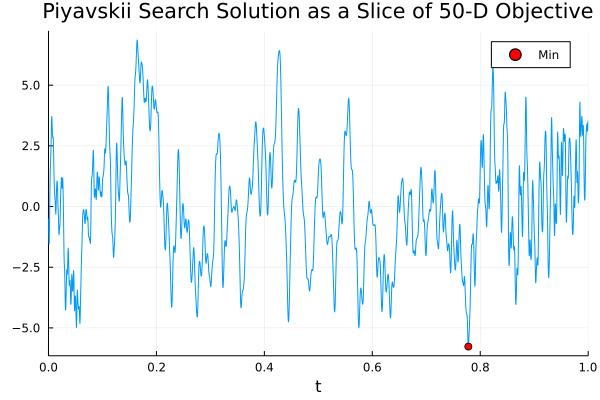

In [16]:
title_string = string("Piyavskii Search Solution as a Slice of ", n, "-D Objective")
plot(phi, xrange = (0, 1), title = title_string, label = false, xlabel = "t")
scatter!([projectedMin[1]], [phi(projectedMin[1])], color=:red, label = "Min")

### Replacing backtracking line search in Gradient Descent with Piyavskii Search

In [74]:
function Back_Line_Search(_x, _f, _fx, _∇f, _Δx, _α, _β, _κ)
    _t = _κ

    while _f(_x + _t*_Δx) > _fx + _α*_t*transpose(_∇f)*_Δx && _t > 1e-8
        _t *= _β
    end

    return _t
end

function Piyavskii_Search(_x, _f, _fx, _∇f, _Δx, _L, _κ)
    _t = _κ
    phi(t) = _f(_x + t*_Δx)
    piya_sol = Piyavskii(phi, 0.0, 1.0, _L, 1e-4, 50)
    return piya_sol[1]
end

Piyavskii_Search (generic function with 1 method)

In [75]:
function Grad_Descent(_f, _x, _α, _β, _ϵ, _κ, _L, maxIt, use_piyavskii_search)
    xtrace = [_x]
    
    it = 0;
    t = 1
    ∇f = _f'(_x)
    normGrad = norm(∇f)
    val = _f(_x)
    
    while normGrad > _ϵ && it < maxIt
        ∇f = _f'(_x)
        normGrad = norm(∇f)

        bls = use_piyavskii_search ? Piyavskii_Search(_x, _f, val, ∇f, -∇f, _L, _κ) : Back_Line_Search(_x, _f, val, ∇f, -∇f, _α, _β, _κ)
        t = bls[1]
        _x -= t*∇f
        val = _f(_x)

        it+=1
        push!(xtrace, _x)
    end
    return _x, val, xtrace
end

Grad_Descent (generic function with 1 method)

In [76]:
f(x) = x[1]*sin(10*x[2]) + x[2]*cos(10*x[1]) + 0.5*x[1]^2 + 0.5*x[2]^2

x0 = [2.0, 2.0]
α = 0.5
β = 0.8
κ = 1
ϵ = 1e-8
L = 500

sol = Grad_Descent(f, x0, α, β, ϵ, κ, L, 1e2, true)

([-1.2543219618451689, -1.0987678638346714], -0.9624490871933683, [[2.0, 2.0], [2.265930357015656, 1.816837113254958], [0.0029021600427094896, -1.454110366183385], [0.010465084751852422, -1.4469867438038104], [0.006065432646651179, -1.4432749785681984], [0.019066498248742007, -1.3637894051245578], [-1.263042767694123, -1.1478682635966106], [-1.2557180996115787, -1.108243307080452], [-1.254545890454448, -1.0993381905684283], [-1.2543533700245781, -1.0987760115643168]  …  [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714], [-1.2543219618451689, -1.0987678638346714]])

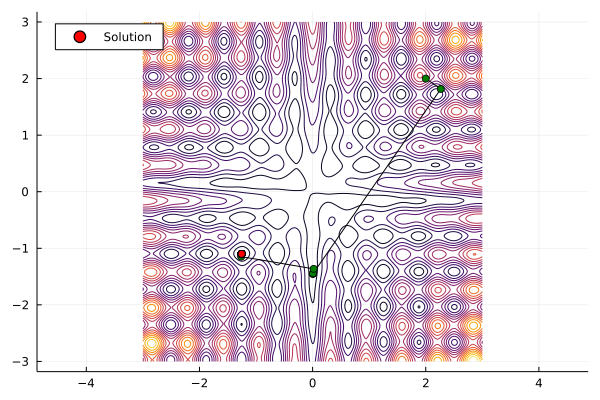

In [77]:
xx = yy = -3:0.01:3
contour(xx, yy, f, dpi = 100, colorbar = false, legend =:topleft, aspect_ratio=:equal)
plot!([sol[3][i][1] for i in 1:length(sol[3])], [sol[3][i][2] for i in 1:length(sol[3])], color=:black, label = false)
scatter!([sol[3][i][1] for i in 1:length(sol[3])], [sol[3][i][2] for i in 1:length(sol[3])], color=:green, label = false)
scatter!([sol[1][1]], [sol[1][2]], color =:red, label = "Solution")